In [ ]:
! pip install langchain-openai langchain-anthropic langgraph 

# Workflows and Agents

Anthropic released an excellent [blog post](https://www.anthropic.com/research/building-effective-agents) on building effective agents. 

It highlights both "agents" and "workflows":

> "Agent" can be defined in several ways. Some customers define agents as fully autonomous systems that operate independently over extended periods, using various tools to accomplish complex tasks. Others use the term to describe more prescriptive implementations that follow predefined "workflows". At Anthropic, we categorize all these variations as agentic systems.

It explains the primary difference between agents and workflows: 

> Workflows are systems where LLMs and tools are orchestrated through predefined code paths.
> Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

Here is a simple way to visualize these differences:

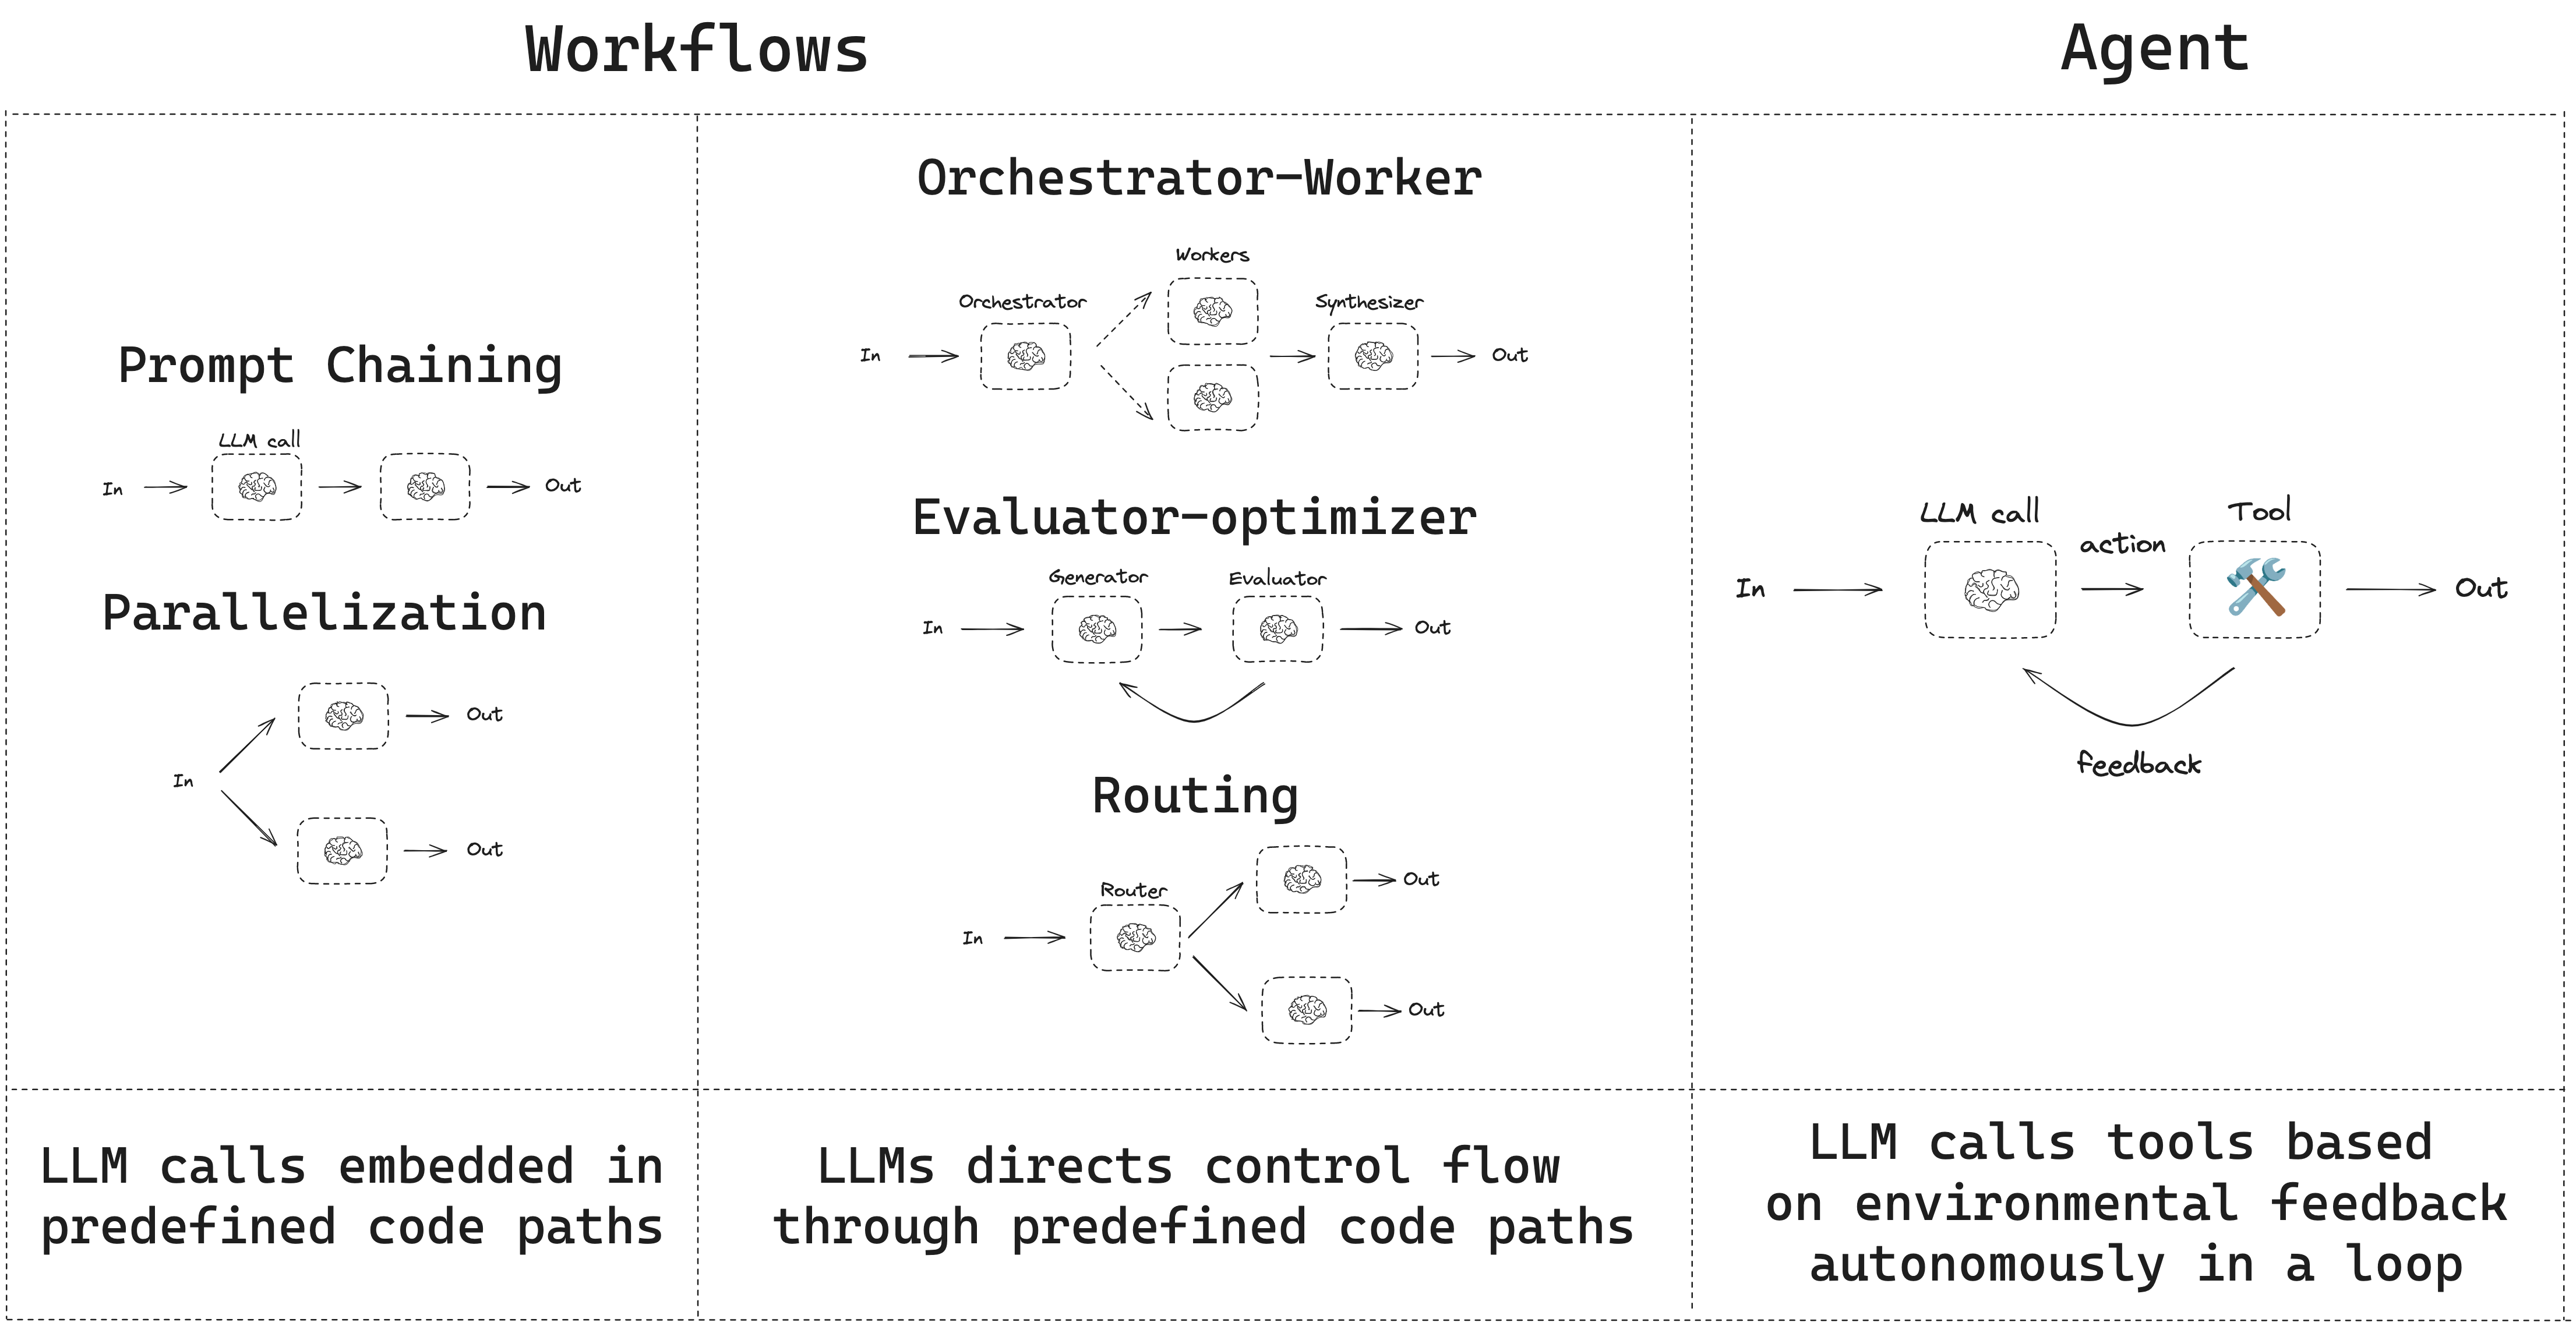

## Why use a framework like LangGraph?

With agents and workflows defined, the blog discusses whether to use agent frameworks.

For any framework, it is important to understand the costs (or overhead) of using it versus the benefits.

The blog points out that frameworks *can* add abstraction, often to promote speed or ease of use. 

But, this can come with costs, such as difficulty debugging or incorrect assumptions.

> (Frameworks) often create extra layers of abstraction that can obscure the underlying prompts and responses, making them harder to debug.

LangGraph aims to minimize overhead by providing low-level building blocks for building workflows / agents.

These building blocks can be flexibly used to build any workflow / agent architecture.

A central building block in LangGraph is the [persistence layer](https://langchain-ai.github.io/langgraph/concepts/persistence/), which sits below any workflow or agent you implement.

This persistence layer enables several features are generally important for agents and workflows:

* Short-term and long-term [memory](https://langchain-ai.github.io/langgraph/concepts/memory/)
* [Interruption and resuming](https://langchain-ai.github.io/langgraph/concepts/breakpoints/) of workflows or agents
* [Human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/) (e.g., to approve an agent's actions)
  
The blog makes an interesting point related to the importance of persistence:
 
> Agents can then *pause for human feedback at checkpoints* or when encountering blockers.

LangGraph also has an ecosystem for [debugging](https://langchain-ai.github.io/langgraph/concepts/high_level/#debugging), [tracing / observability, evaluation](https://docs.smith.langchain.com/), and [deploying](https://langchain-ai.github.io/langgraph/concepts/high_level/#deployment) any workflow / agent architecture.

## Building Blocks: The Augmented LLM 

LLM have [augmentations](https://www.anthropic.com/research/building-effective-agents) that support building workflows and agents. 

These include `structured outputs` and `tool calling`, as shown in the blog:

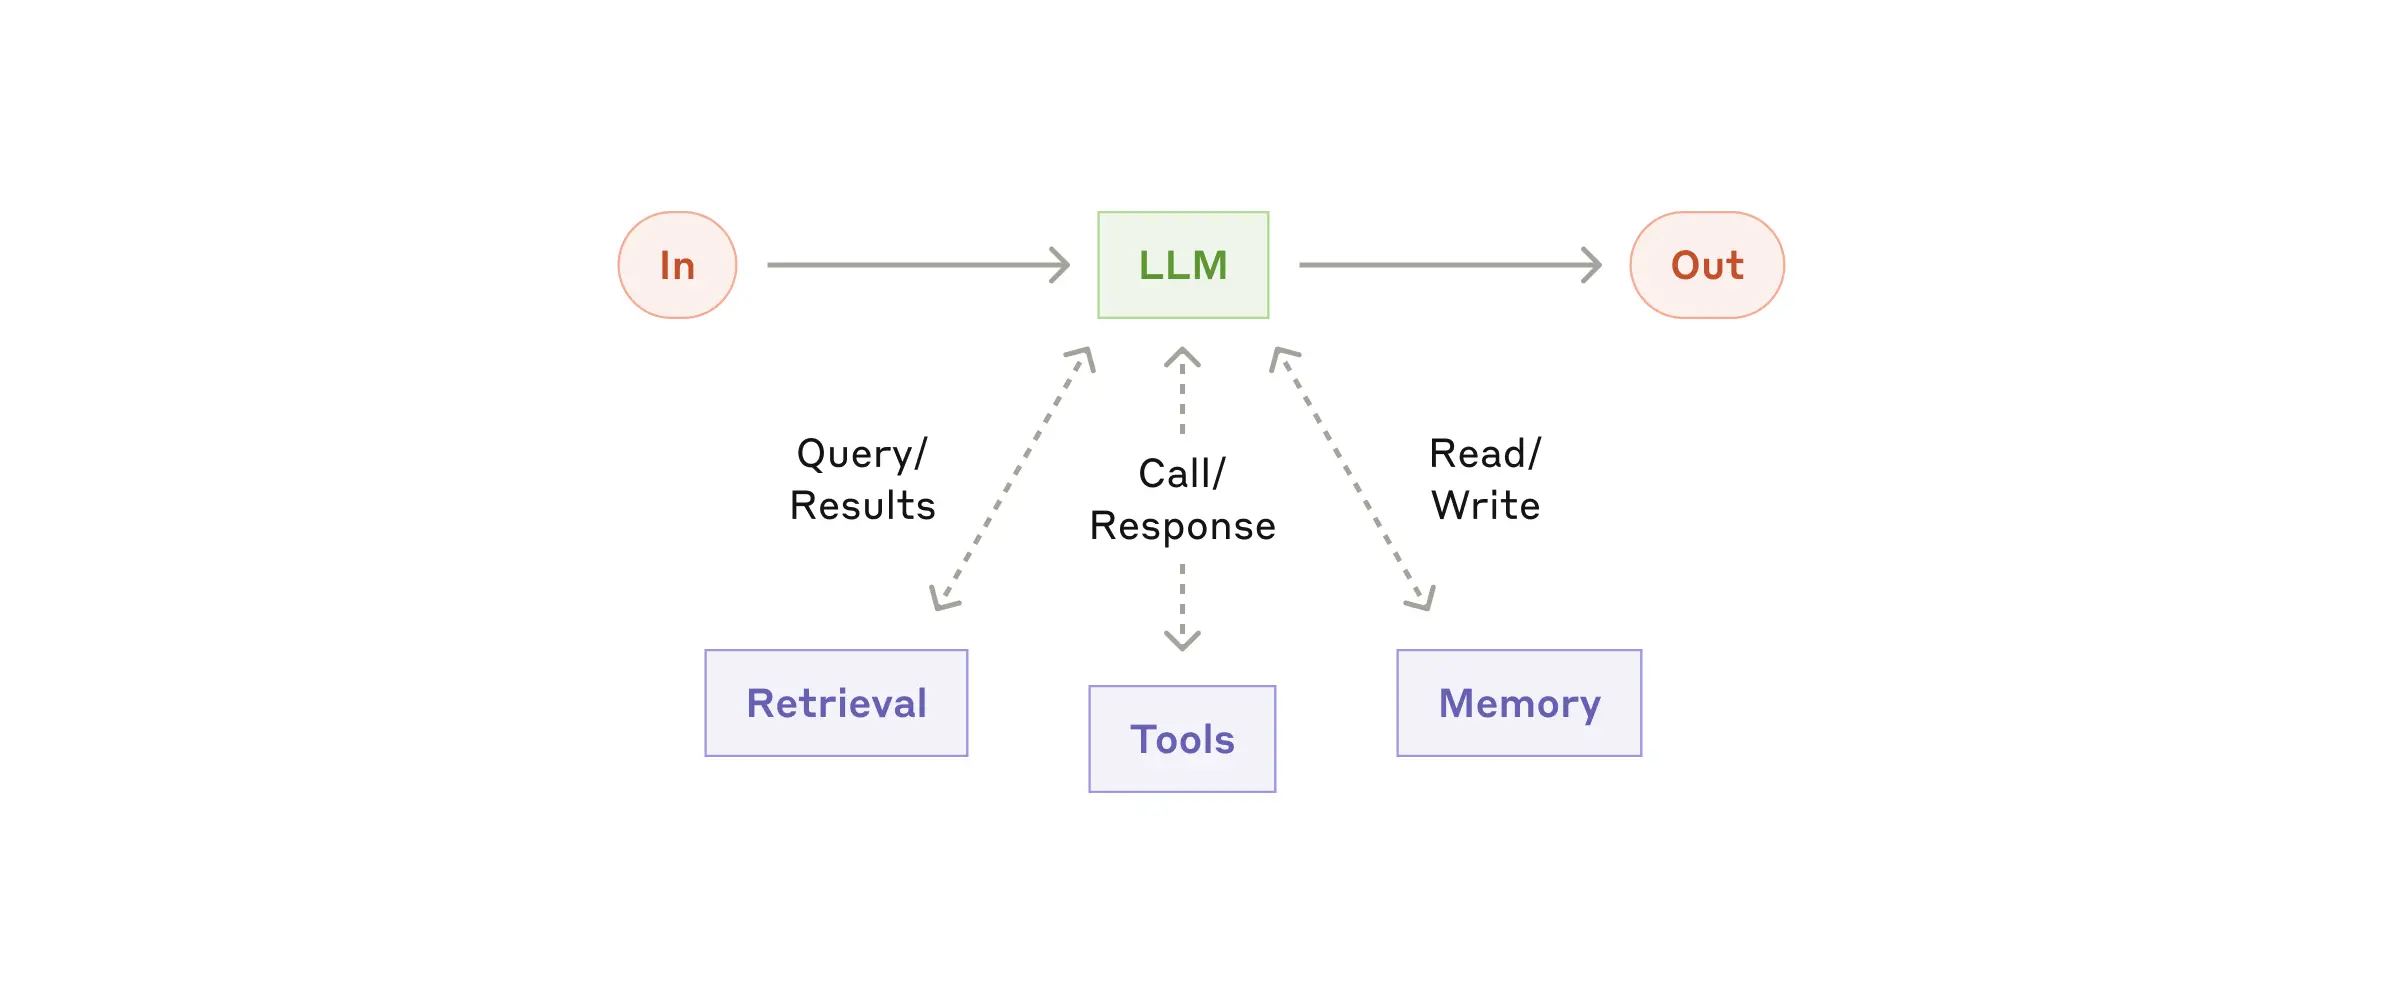

LangGraph uses these augmentations to build workflows and agents.

In [3]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [4]:
from pydantic import BaseModel, Field

# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query that is optimized web search."
    )
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

relationship between coronary calcium score and high cholesterol levels
This search will help find scientific information about how coronary artery calcium scoring correlates with cholesterol levels and cardiovascular risk.


In [12]:
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_IyRywjX46Ks1JAVuYghRP1jh',
  'type': 'tool_call'}]

## Prompt chaining

In prompt chaining, each LLM call processes the output of the previous one. 

As noted in the [blog](https://www.anthropic.com/research/building-effective-agents): 

> Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

> When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

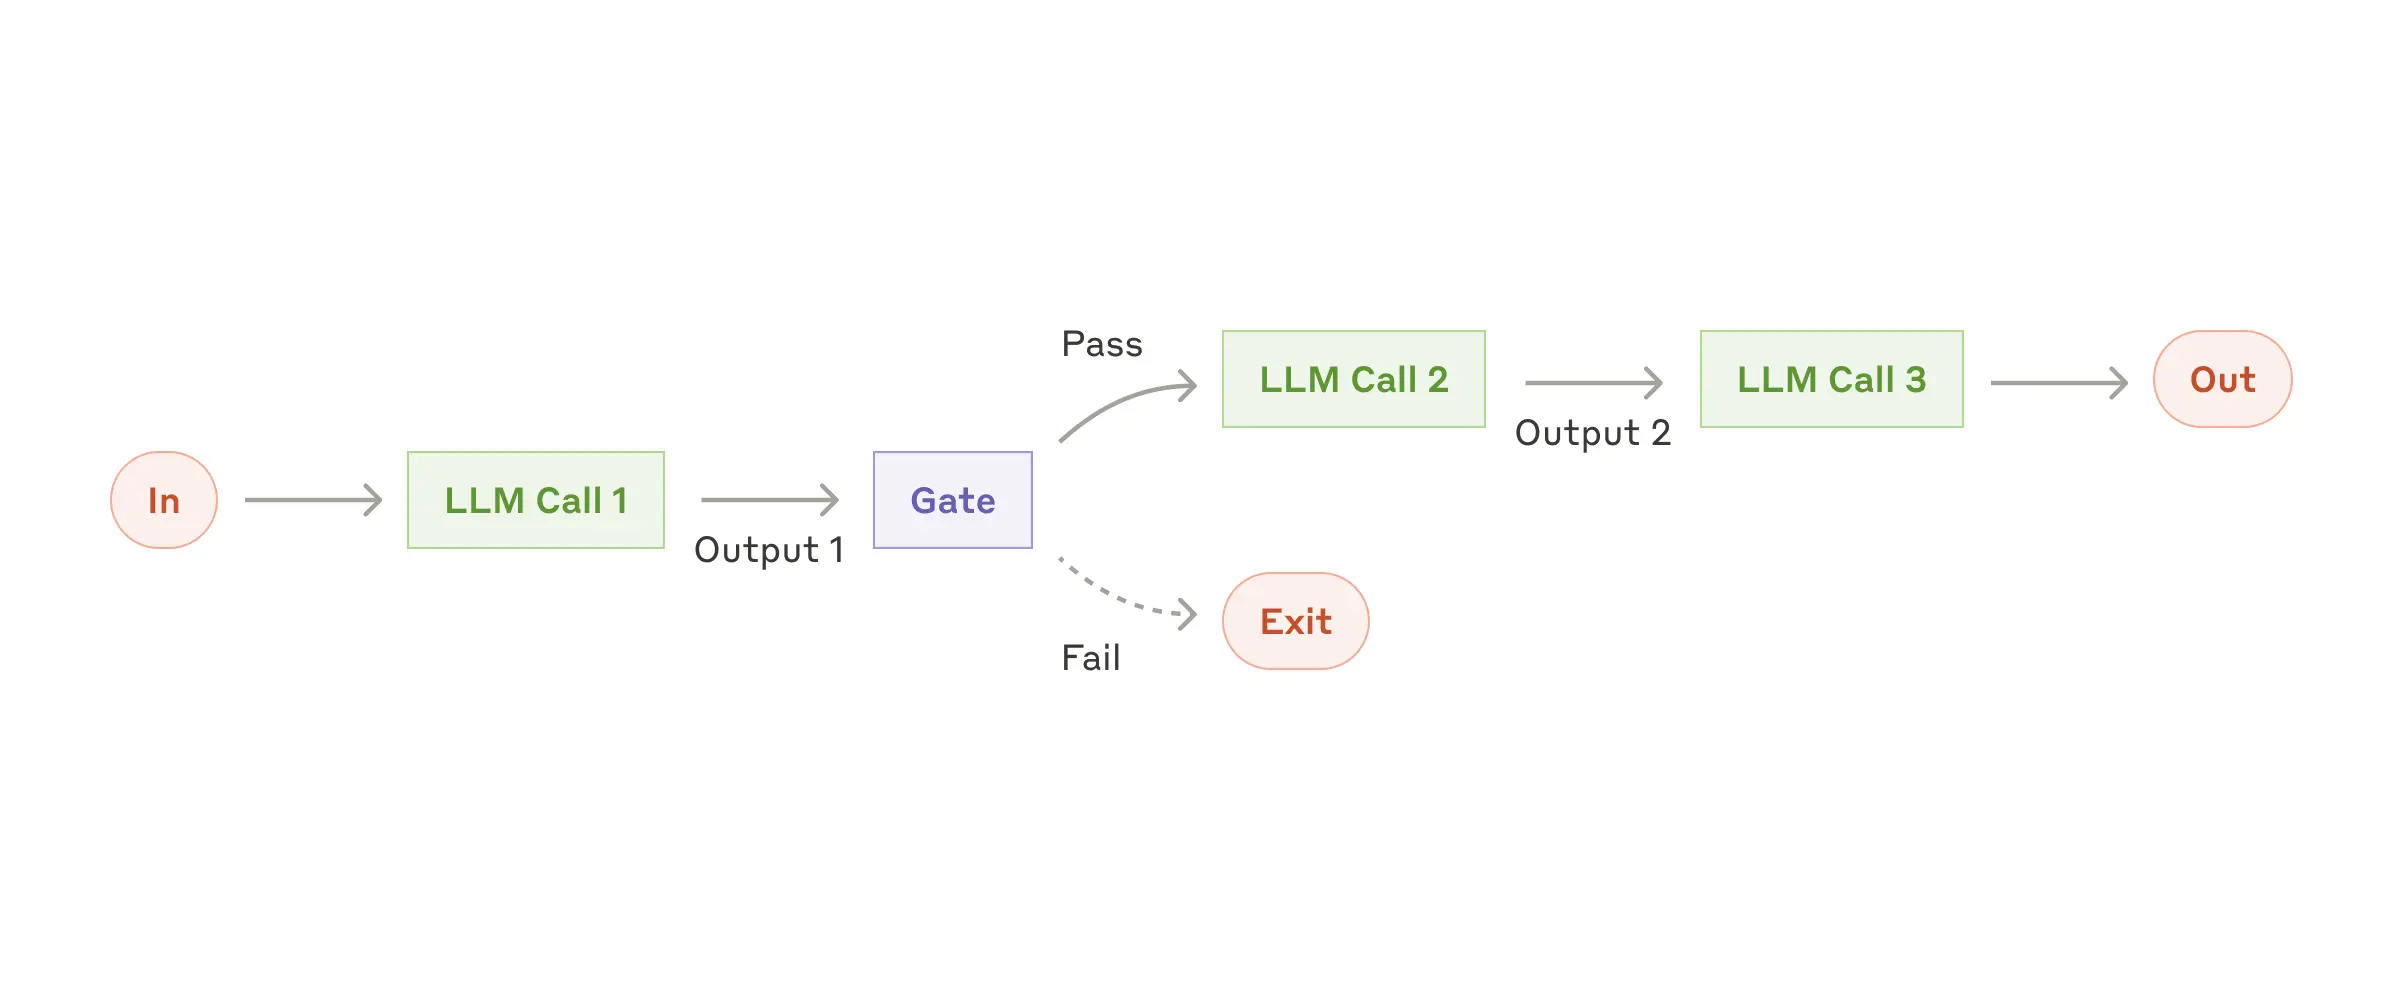

#### Resources

**LangChain Academy**
 
See our lesson on Prompt Chaining here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb

#### Example Implementation


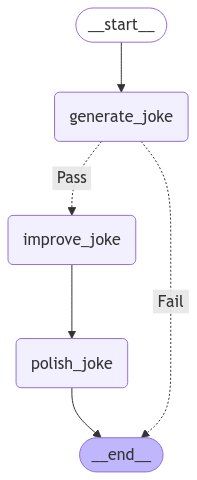

In [45]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# LLM
llm = ChatOpenAI(model="gpt-4o")

# State 
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

def generate_joke(state: State):
    """ First LLM call to generate initial joke """
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """ Gate function to check if the joke has a punchline """
    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"  

def improve_joke(state: State):
    """ Second LLM call to improve the joke """
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """ Third LLM call for final polish """
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Build chain 
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke",
    check_punchline,
    {
        "Pass": "improve_joke",
        "Fail": END
    }
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show chain 
display(Image(chain.get_graph().draw_mermaid_png()))

In [47]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state['joke'])
print("\n--- --- ---\n")
if 'improved_joke' in state:
    print("Improved joke:")
    print(state['improved_joke'])
    print("\n--- --- ---\n")
    
    print("Final joke:")
    print(state['final_joke'])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
Why was the cat sitting on the computer?

Because it wanted to paw-se the mouse and take a byte out of cyberspace!

--- --- ---

Final joke:
Why was the cat sitting on the computer?

Because it wanted to paw-se the mouse and take a byte out of cyberspace—but instead, it accidentally hacked into the neighbor's Wi-Fi and ordered a year's supply of tuna!


#### LangSmith Trace

https://smith.langchain.com/public/a0281fca-3a71-46de-beee-791468607b75/r

## Parallelization 

With parallelization, LLMs work simultaneously on a task. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

>LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

> When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

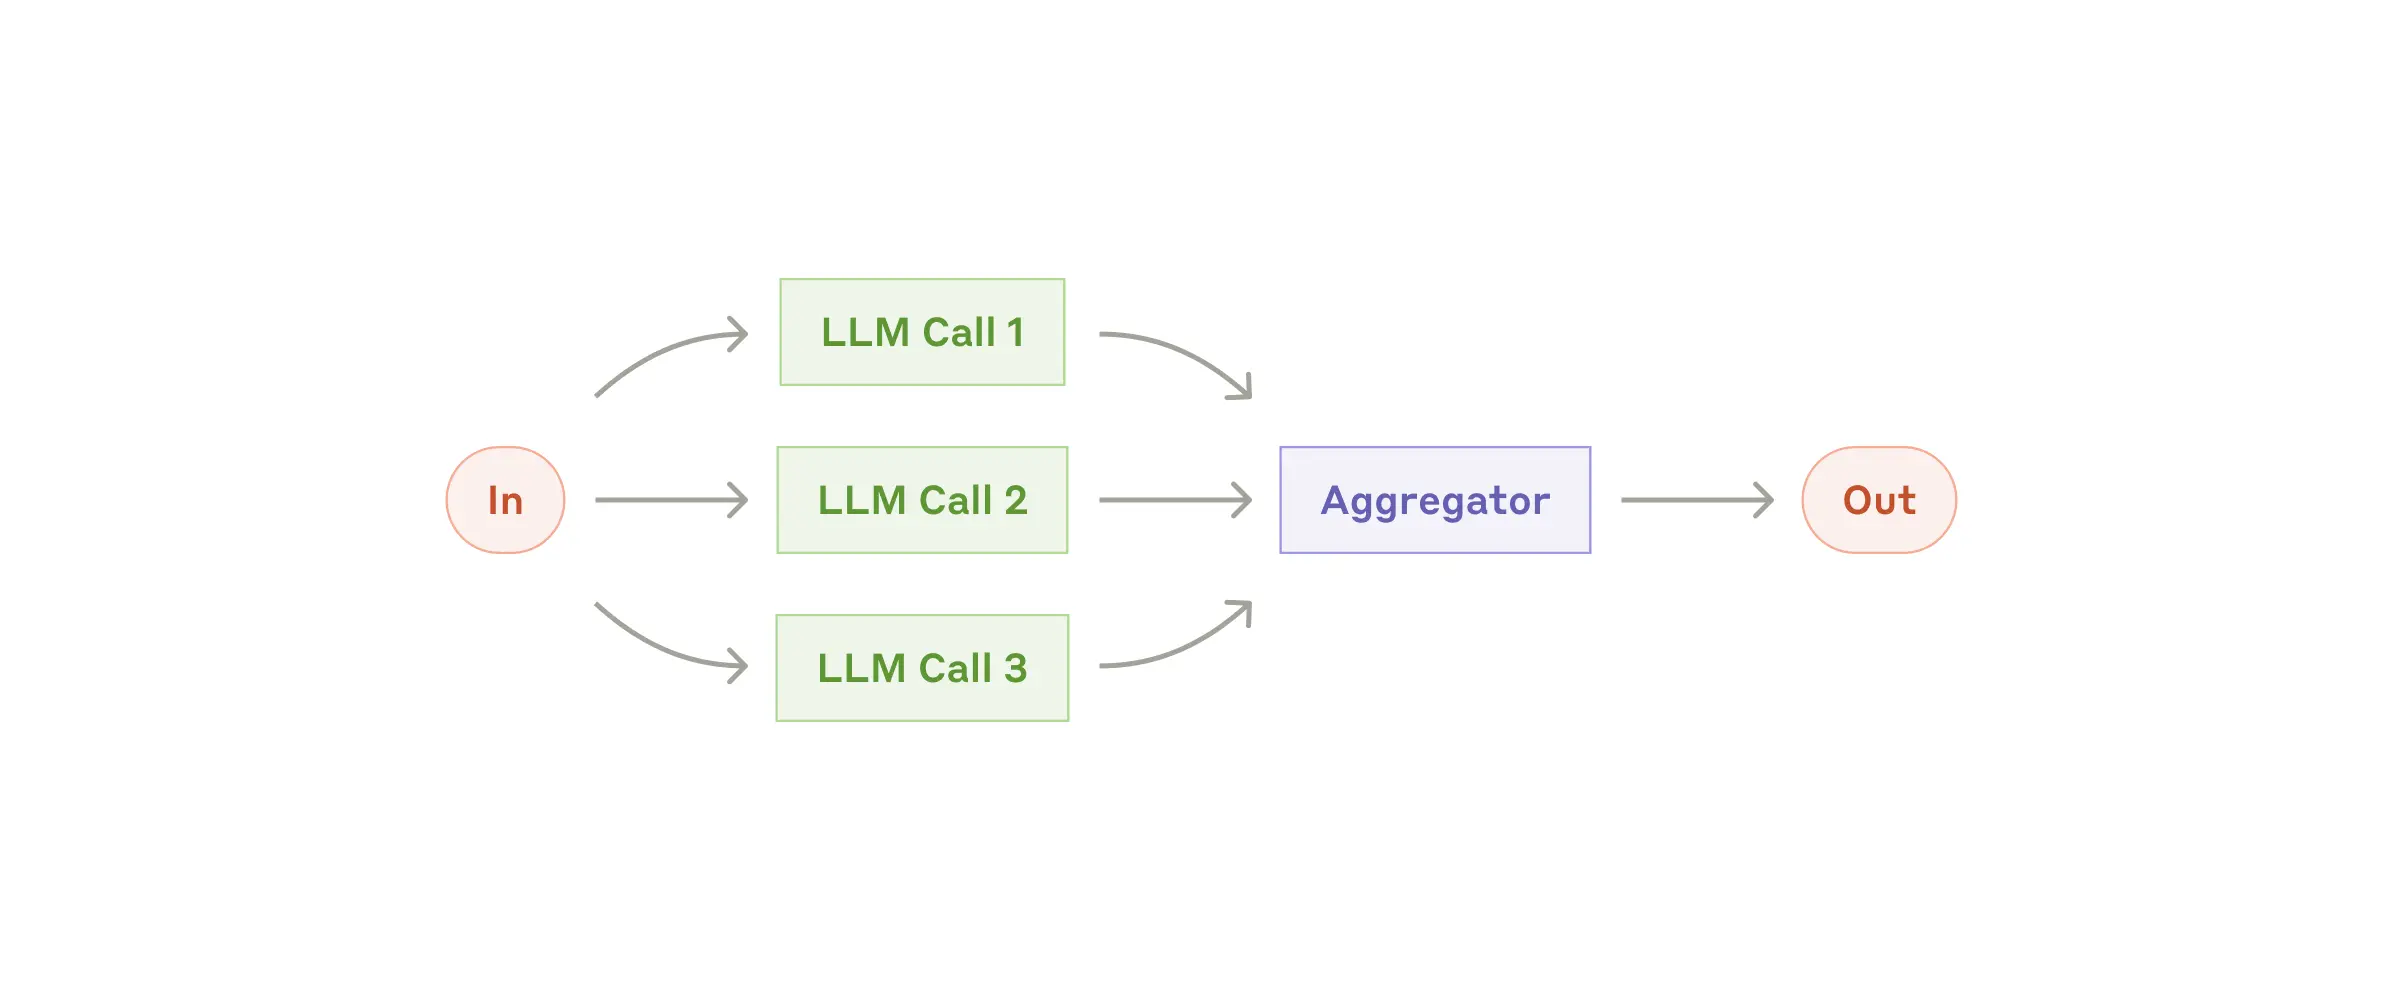

#### Resources

**Documentation**

See our documentation on parallelization here:

https://langchain-ai.github.io/langgraph/how-tos/branching/

**LangChain Academy**
 
See our lesson on parallelization here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/simple-graph.ipynb

#### Example Implementation

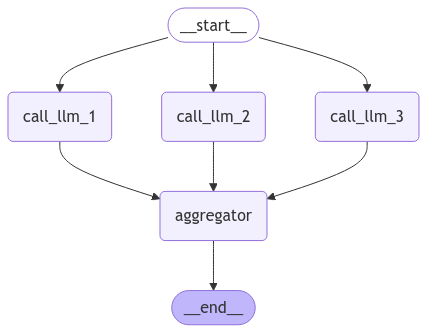

In [7]:
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

def call_llm_1(state: State):
    """ First LLM call to generate initial joke """
    msg=llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: State):
    """ Second LLM call to generate story """
    msg=llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    """ Third LLM call to generate poem """
    msg=llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """ Combine the joke and story into a single output """
    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

# Add the nodes
parallel_builder = StateGraph(State)
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Build the workflow
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator") 
parallel_builder.add_edge("call_llm_3", "aggregator") 
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show the workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [ ]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state['combined_output'])

#### LangSmith Trace

https://smith.langchain.com/public/3be2e53c-ca94-40dd-934f-82ff87fac277/r

## Routing 

Routing classifies an input and directs it to a specialized followup task. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

> Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

> When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

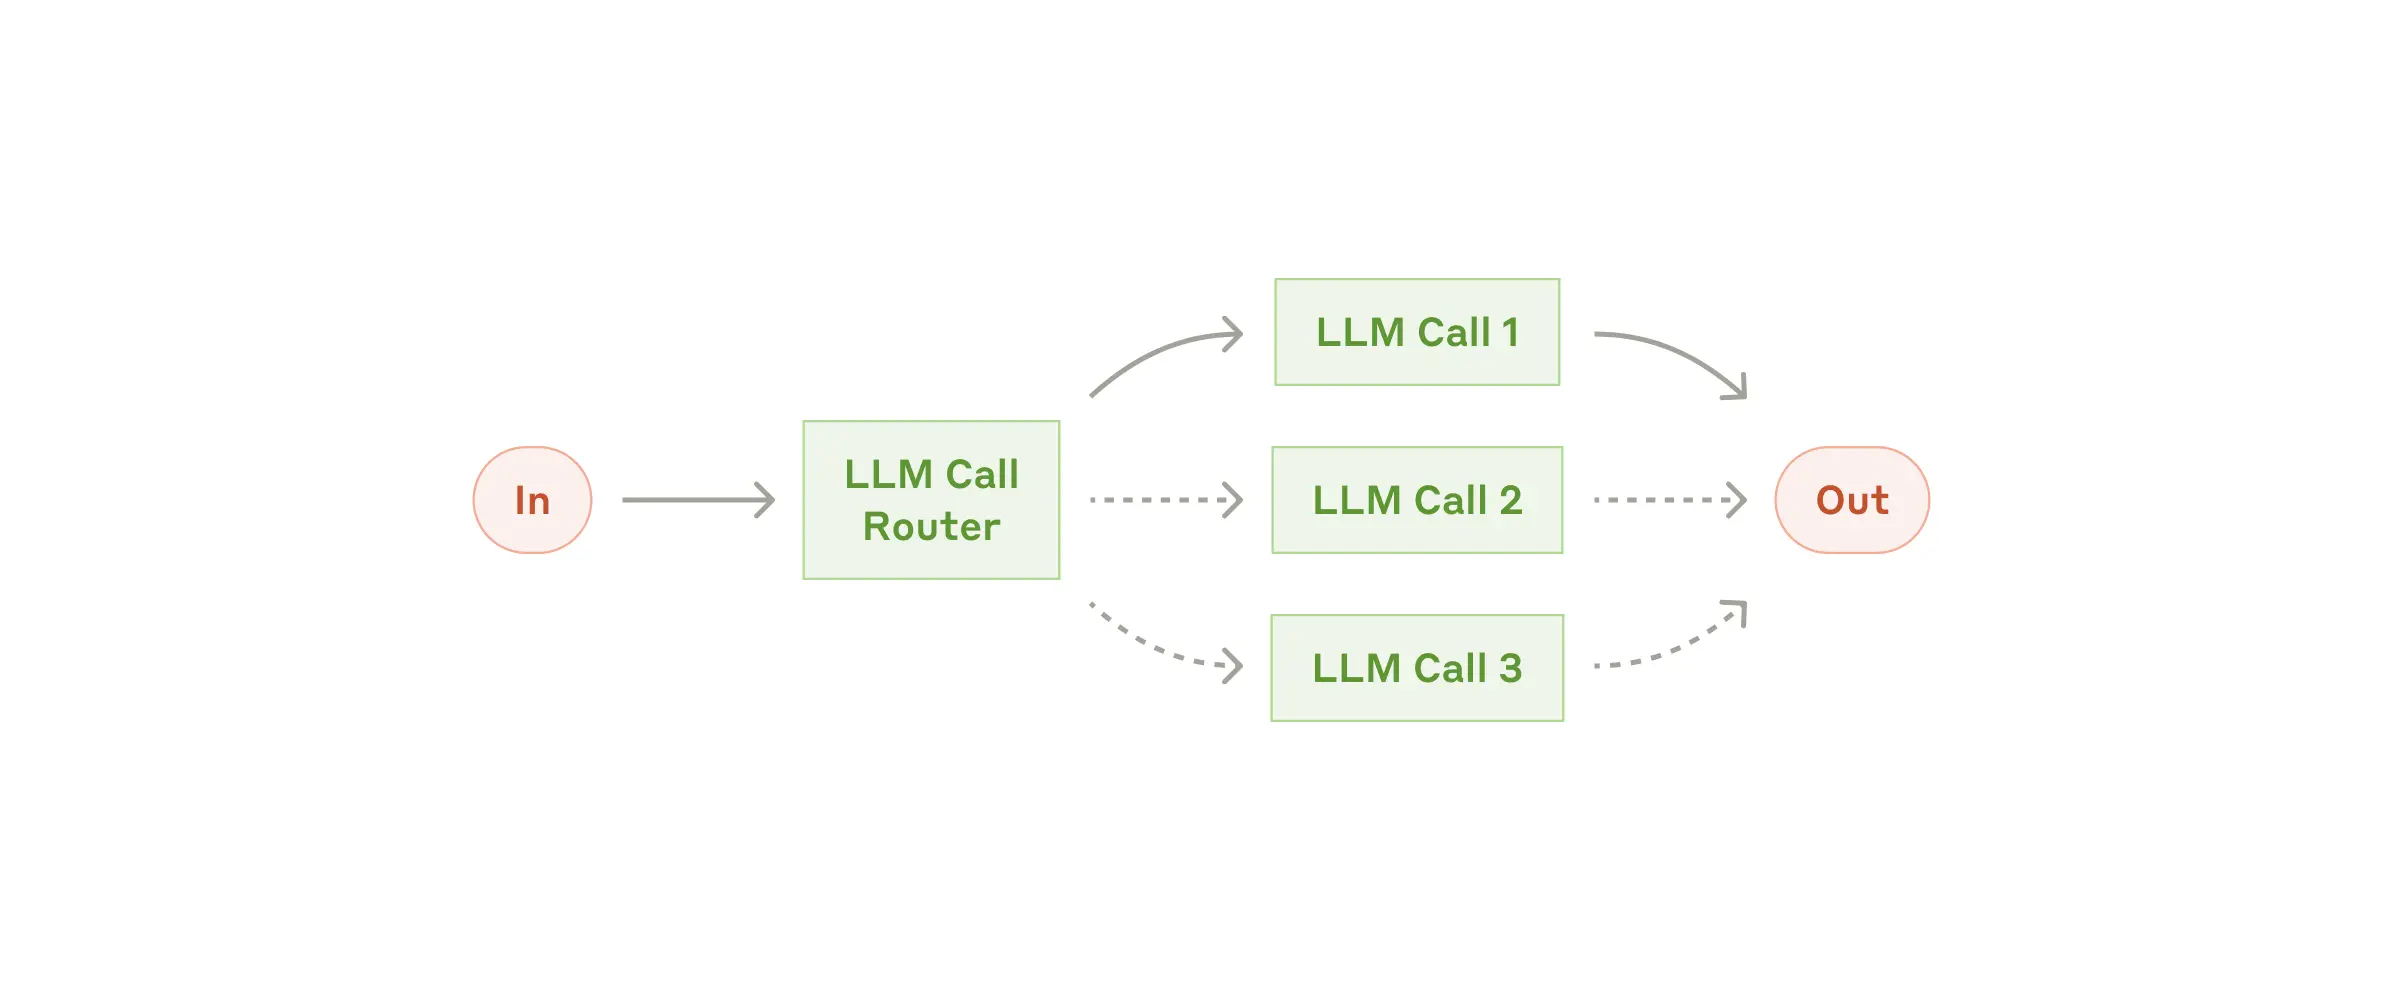

#### Resources

**LangChain Academy**

See our lesson on routing here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb

**Examples**

Here is a project on RAG that utilizes routing to route questions to a vectorstore or web search: 

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/ 

See our video on here:

https://www.youtube.com/watch?v=bq1Plo2RhYI

#### Example Implementation

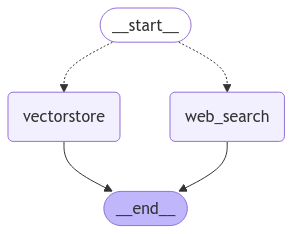

In [46]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["vectorstore", "web_search"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State 
class State(TypedDict):
    question: str
    search_results: str

def web_search(state: State):
    """ Run web search """
    print(f"Run web search with '{state['question']}'!")
    return {"search_results": "foo"}

def vectorstore(state: State):
    """ Run vectorstore search """
    print(f"Run vectorstore search with '{state['question']}'!")
    return {"search_results": "bar"}

def llm_call_router(state: State):
    """ Route the question to the appropriate node """
    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke([SystemMessage(content="Route current events to web_search and question about LangGraph to vectorstore."), 
                              HumanMessage(content=state["question"])])
    
    # Return the node name you want to visit next
    if decision.step == "vectorstore":
        return "vectorstore" 
    elif decision.step == "web_search":
        return "web_search"

# Add the nodes
router_builder = StateGraph(State)
router_builder.add_node("web_search", web_search)
router_builder.add_node("vectorstore", vectorstore)

# Set the conditional entry point that runs llm_call_router and routes to the next node
router_builder.set_conditional_entry_point(
    llm_call_router,
    {   # Name returned by llm_call_router : Next node to visit
        "web_search": "web_search",
        "vectorstore": "vectorstore",
    },
)

# Add edges
router_builder.add_edge("web_search", END)
router_builder.add_edge("vectorstore", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow 
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [47]:
state = router_workflow.invoke({"question": "Did the Ram or Vikings win on Monday night?"})
print(state['search_results'])

Run web search with 'Did the Ram or Vikings win on Monday night?'!
foo


#### LangSmith Trace

https://smith.langchain.com/public/f26382b1-6bb9-4d00-8138-32a9756dea0b/r

## Orchestrator-Worker 

A central LLM dynamically breaks down task, delegates them to worker LLMs, and synthesizes their results. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

> In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

> When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

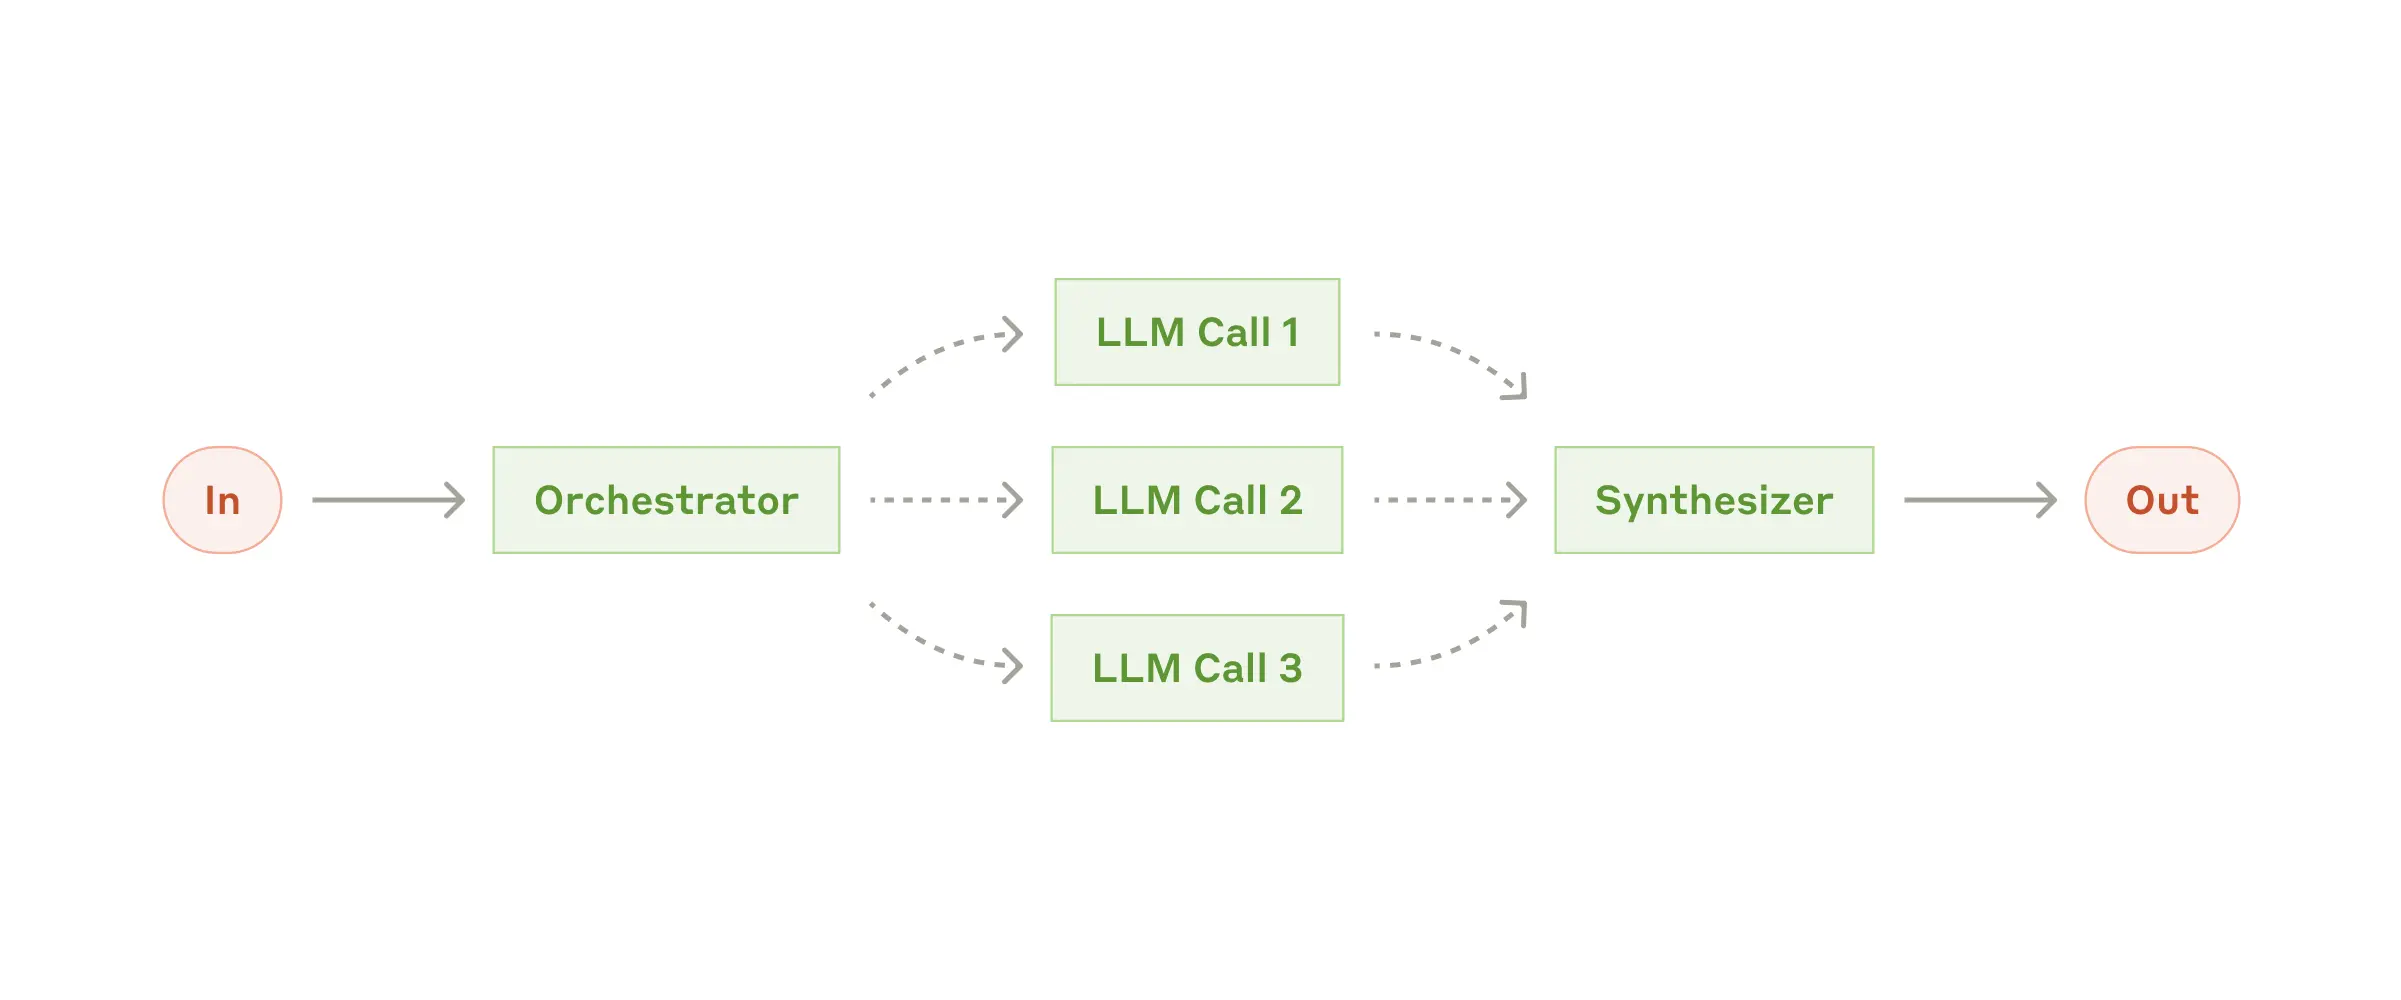

#### Resources

**Documentation**

See our documentation on orchestrator-worker here:

https://langchain-ai.github.io/langgraphjs/how-tos/map-reduce/

https://langchain-ai.github.io/langgraph/concepts/low_level/#send

---

**LangChain Academy**

See our lesson on orchestrator-worker here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb

--- 

**Examples**

Here is a project that uses orchestrator-worker for report planning and writing:

https://github.com/langchain-ai/report-mAIstro

See our video here:

https://www.youtube.com/watch?v=wSxZ7yFbbas
    
#### Example Implementation


In [20]:
from typing import Annotated,List
import operator

# Schema for structured output to use in planning 
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM
planner = llm.with_structured_output(Sections)

In [48]:
from langgraph.constants import Send

# Graph state
class State(TypedDict):
    topic: str # Report topic
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # All workers write to this key in parallel
    final_report: str # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add] 

def orchestrator(state: State):
    """ Orchestrator that generates a plan for the report """

    # Generate queries  
    report_sections = planner.invoke([SystemMessage(content="Generate a plan for the report."),
                                      HumanMessage(content=f"Here is the report topic: {state['topic']}")])

    return {"sections": report_sections.sections}

def assign_workers(state: State):
    """ Assign a worker to each section in the plan """    
    
    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"] ]

def llm_call(state: WorkerState):
    """ Worker writes a section of the report """

    # Generate section  
    section = llm.invoke([SystemMessage(content="Write a report section."),
                          HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}")])
    
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

def synthesizer(state: State):
    """ Synthesize full report from sections """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

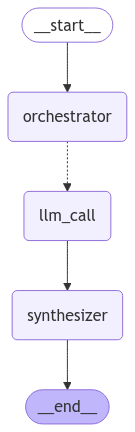

In [49]:
# Add the nodes
orchestrator_worker_builder = StateGraph(State)
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow 
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [23]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

In [ ]:
from IPython.display import Markdown
Markdown(state['final_report'])

#### LangSmith Trace

https://smith.langchain.com/public/78cbcfc3-38bf-471d-b62a-b299b144237d/r

## Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

> In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

> When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

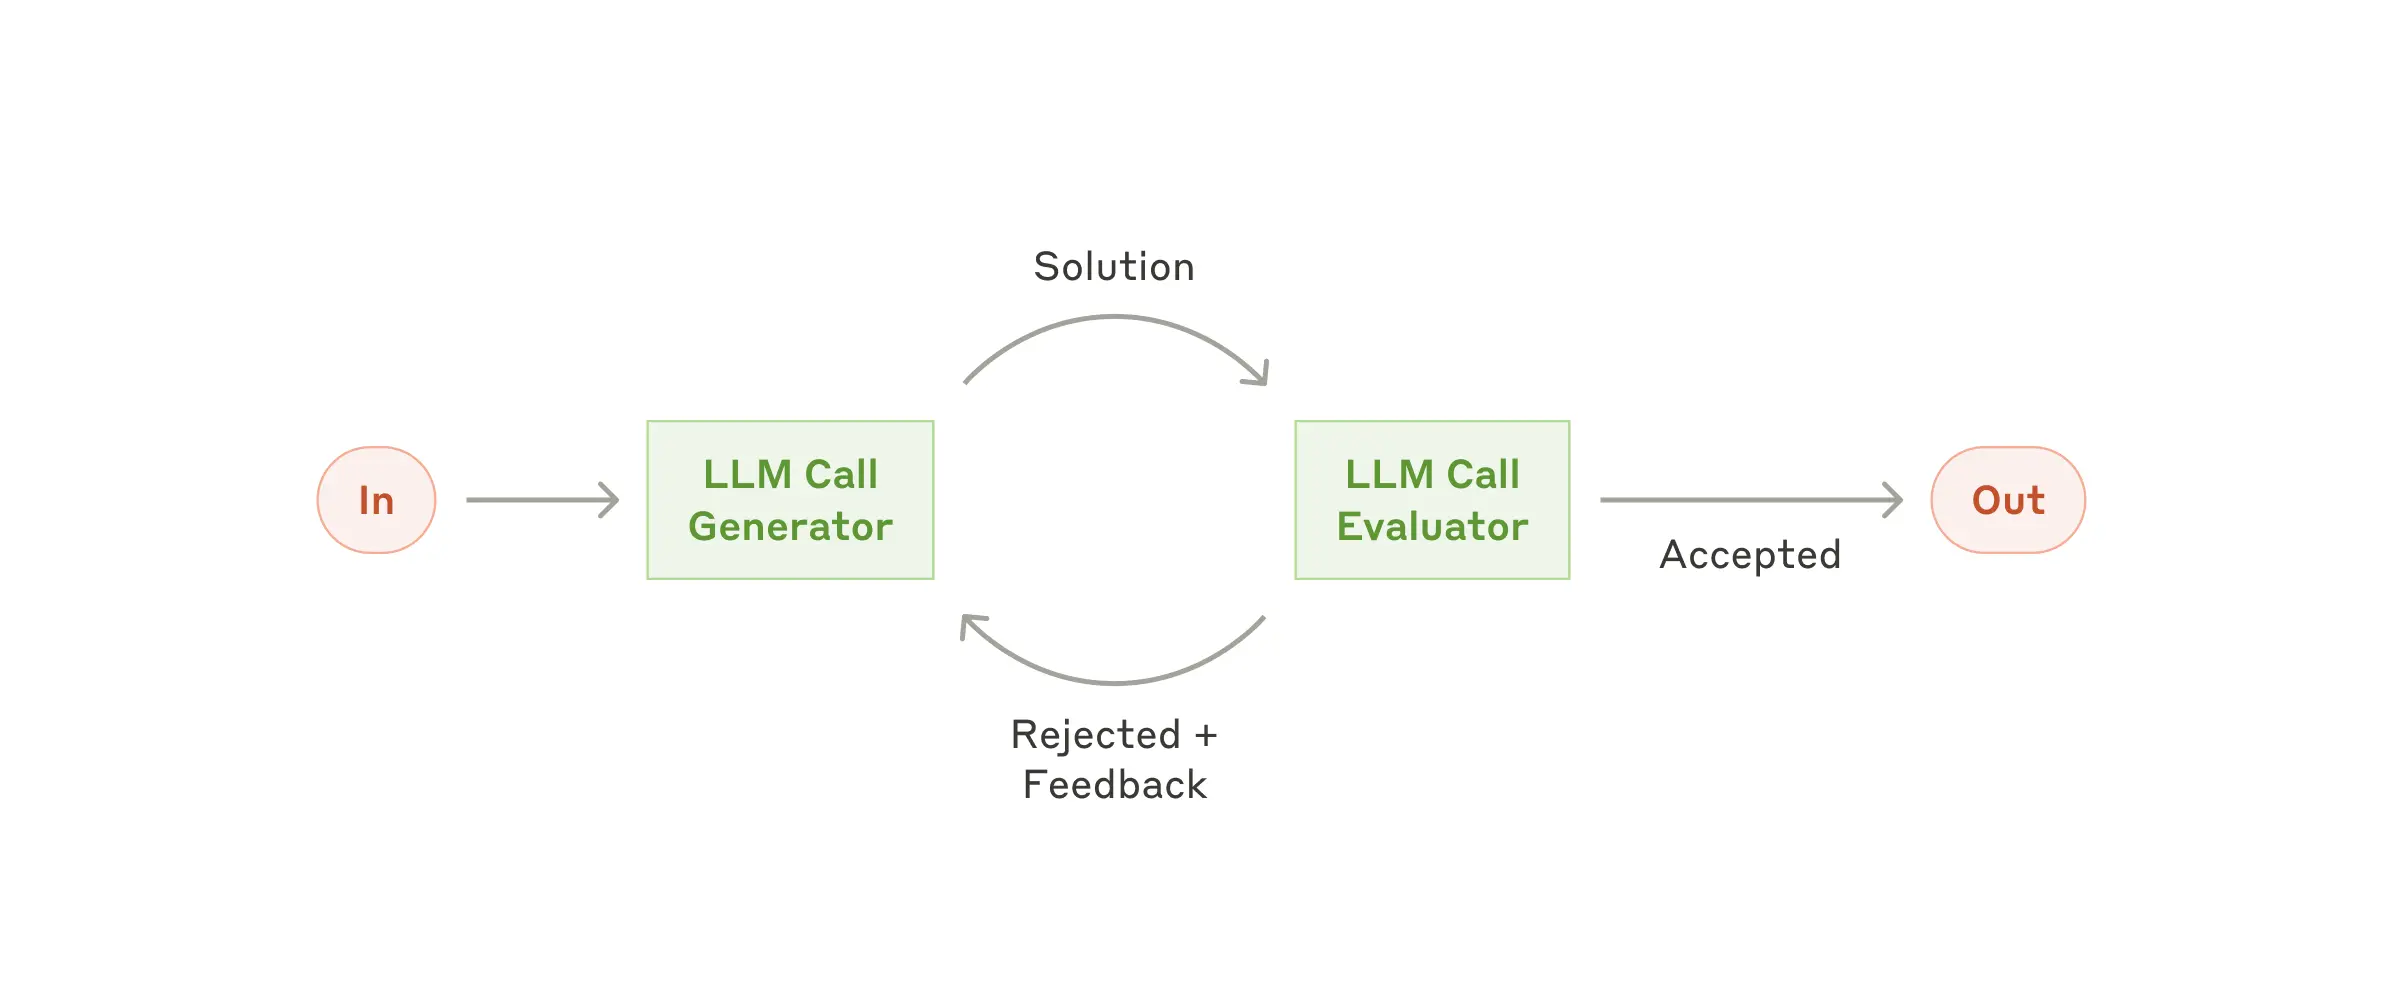

#### Resources

**Examples**

Here is a project that uses evaluator-optimizer to iteratively improve a report:

https://github.com/langchain-ai/research-rabbit

See our video on here:

https://www.youtube.com/watch?v=XGuTzHoqlj8

--- 

Here is a project on RAG that utilizes grading to check answers for hallucinations or factual errors: 

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/ 

See our video on here:

https://www.youtube.com/watch?v=bq1Plo2RhYI

#### Example Implementation

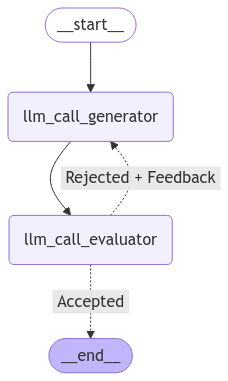

In [51]:
# State 
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Augment the LLM
evaluator = llm.with_structured_output(Feedback)

def llm_call_generator(state: State):
    """ LLM generates a joke """
    if state.get('feedback'):
        msg=llm.invoke(f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}")
    else:
        msg=llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """ LLM evaluates the joke """
    grade=evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

def route_joke(state: State):
    """ Route back to joke generator or end based upon feedback from the evaluator """
    if state['funny_or_not'] == "funny":
        return "Accepted" 
    elif state['funny_or_not'] == "not funny":
        return "Rejected + Feedback"

# Add the nodes
optimizer_builder = StateGraph(State)
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Build the chain
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges("llm_call_evaluator", 
                                        route_joke, 
                                        { "Accepted": END,
                                            "Rejected + Feedback": "llm_call_generator"
                                        })
optimizer_workflow = optimizer_builder.compile()

# Show the chain 
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [52]:
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state['joke'])

Why was the cat sitting on the computer?  

Because it wanted to keep an eye on the mouse!


#### LangSmith Trace

https://smith.langchain.com/public/86ab3e60-2000-4bff-b988-9b89a3269789/r

## Agent 

Agents are typically just LLMs using tools based on environmental feedback in a loop. As noted in the [Anthropic blog post](https://www.anthropic.com/research/building-effective-agents): 

> Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

> When to use agents: Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

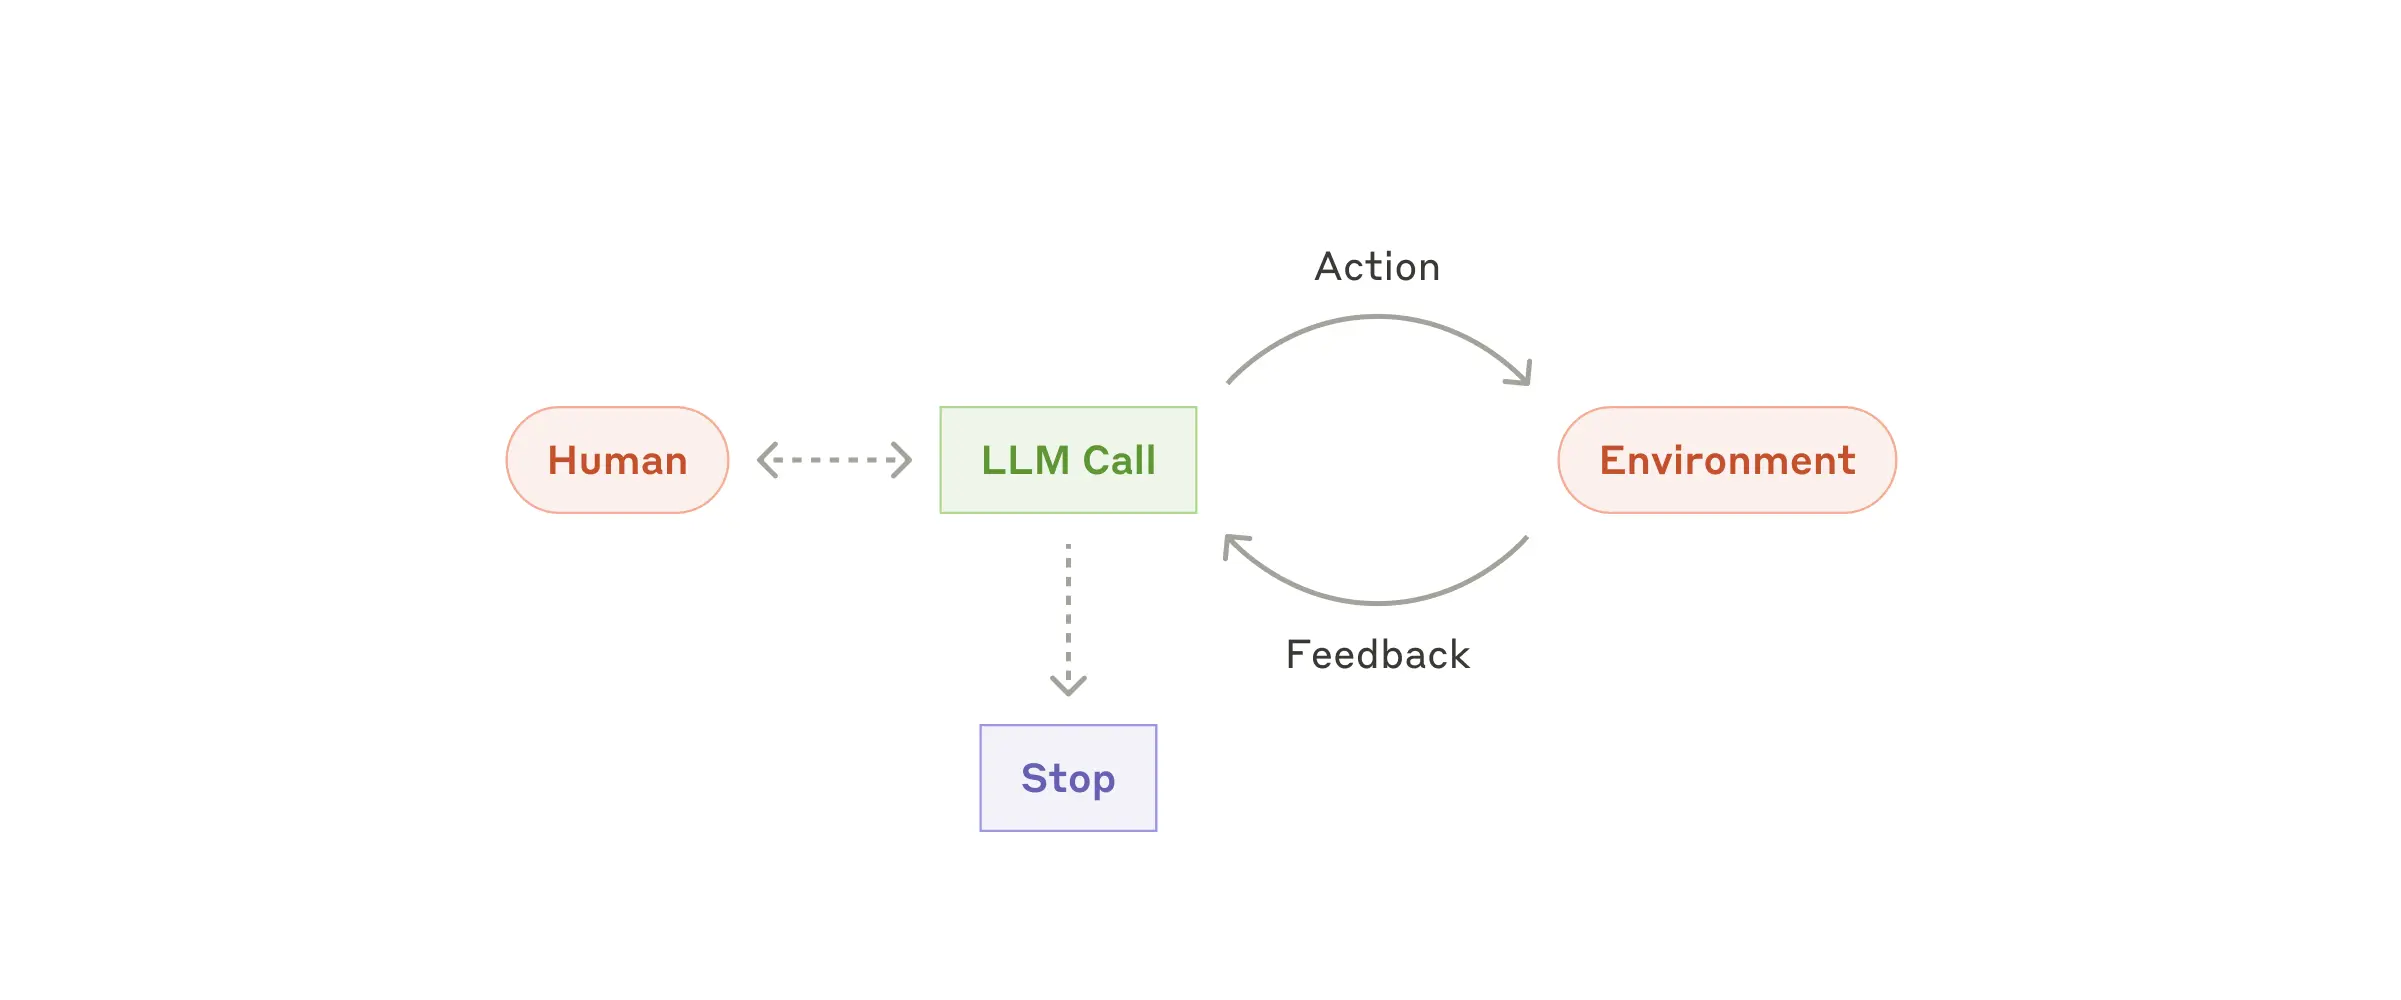

#### Resources

**Documentation**

See additional documentation here:

https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/

**LangChain Academy**

See our lesson on agents here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb

--- 

**Examples**

Here is a project that uses a tool calling agent to create / store long-term memories:

https://github.com/langchain-ai/memory-agent

#### Example Implementation

In [42]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

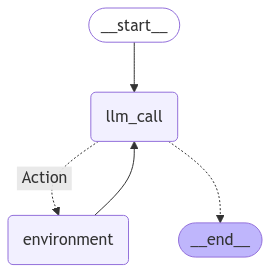

In [59]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

def llm_call(state: MessagesState):
    """ LLM decides whether to call a tool or not """
    return {"messages": [llm_with_tools.invoke([SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")] + state["messages"])]}

def tool_node(state: dict):
    """ Performs the tool call """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["environment", END]:
    """ Decide if we should continue the loop or stop based upon whether the LLM made a tool call """
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "environment" node
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

# Graph
agent_builder = StateGraph(MessagesState)
agent_builder.add_node("llm_call", llm_call)
# Performs the tool call
agent_builder.add_node("environment", tool_node)
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    # If the latest message (result) from llm_call is a tool call -> should_continue routes to environment (tool node)
    # If the latest message (result) from llm_call is a not a tool call -> should_continue routes to END
    should_continue,
    { "Action": "environment",
      END: END,
    }
)
agent_builder.add_edge("environment", "llm_call")
agent = agent_builder.compile()

# Show
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [60]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = agent.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_DDwZdSEh9pjWgxOXStdvBEXF)
 Call ID: call_DDwZdSEh9pjWgxOXStdvBEXF
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_t2o9jlEk2ffg0n2ynwZQoJ8c)
 Call ID: call_t2o9jlEk2ffg0n2ynwZQoJ8c
  Args:
    a: 7
    b: 2
================================= Tool Message =================================

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_c9p0JOF2M11m43VJtRcmuNzI)
 Call ID: call_c9p0JOF2M11m43VJtRcmuNzI
  Args:
    a: 14
    b: 5
================================= Tool Message =================================

2.8
=

#### LangSmith Trace

https://smith.langchain.com/public/75a8b245-3e46-4e7e-acd1-9759d22d059e/r

## Learning More

### Checkpoints and Human-in-the-Loop

See module 3 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-3

### Memory 

See modules 2 and 5 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-2

https://github.com/langchain-ai/langchain-academy/tree/main/module-5

### Deployment 

See module 6 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-6